In [2]:
# !unzip /content/ANN_WS24_Assignment.zip -d /content/ANN_WS24_Assignment

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
def load_dataset(base_path):
    """
    Load images from subfolders, assuming each subfolder represents a class
    """
    images = []
    labels = []

    for label_idx, label_folder in enumerate(sorted(os.listdir(base_path))):
        folder_path = os.path.join(base_path, label_folder)
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith('.npy'):
                    img_path = os.path.join(folder_path, img_file)
                    img = np.load(img_path)
                    images.append(img.squeeze())
                    labels.append(label_idx)

    return np.array(images), np.array(labels)

In [28]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
def train_and_evaluate():
    # Load datasets
    X_train, y_train = load_dataset('/content/ANN_WS24_Assignment/TRAIN')
    X_test, y_test = load_dataset('/content/ANN_WS24_Assignment/TEST')
    X_test2, y_test2 = load_dataset('/content/ANN_WS24_Assignment/TEST2')

    # Reshape and normalize
    X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
    X_test = X_test.reshape(-1, 28, 28, 1) / 255.0
    X_test2 = X_test2.reshape(-1, 28, 28, 1) / 255.0

    # Convert labels
    y_train = tf.keras.utils.to_categorical(y_train, 6)
    y_test = tf.keras.utils.to_categorical(y_test, 6)
    y_test2 = tf.keras.utils.to_categorical(y_test2, 6)

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # Task 1: Initial Training
    print("Task 1: Training initial model...")
    model = create_model()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate on TEST
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'\nTEST accuracy: {test_acc*100:.2f}%')
    plot_results(history, model, X_test, y_test, "TEST")

    # Evaluate on TEST2
    test2_loss, test2_acc = model.evaluate(X_test2, y_test2)
    print(f'\nTEST2 accuracy: {test2_acc*100:.2f}%')
    plot_results(history, model, X_test2, y_test2, "TEST2")

    # Task 2: Fine-tuning with TEST data
    print("\nTask 2: Fine-tuning with TEST data...")
    fine_tuned_model = create_model()
    fine_tuned_model.set_weights(model.get_weights())

    # Freeze layers
    for layer in fine_tuned_model.layers[:-4]:
        layer.trainable = False

    fine_tuned_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_ft = fine_tuned_model.fit(
        X_test, y_test,
        validation_data=(X_test2, y_test2),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate fine-tuned model on TEST
    test_loss_ft, test_acc_ft = fine_tuned_model.evaluate(X_test, y_test)
    print(f'\nTEST accuracy after fine-tuning: {test_acc_ft*100:.2f}%')
    plot_results(history_ft, fine_tuned_model, X_test, y_test, "TEST after fine-tuning")

    # Evaluate fine-tuned model on TEST2
    test2_loss_ft, test2_acc_ft = fine_tuned_model.evaluate(X_test2, y_test2)
    print(f'\nTEST2 accuracy after fine-tuning: {test2_acc_ft*100:.2f}%')
    plot_results(history_ft, fine_tuned_model, X_test2, y_test2, "TEST2 after fine-tuning")

Task 1: Training initial model...
Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 112s 95ms/step - accuracy: 0.8173 - loss: 0.5903 - val_accuracy: 0.4927 - val_loss: 2.5157 - learning_rate: 0.0010
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.9483 - loss: 0.1590 - val_accuracy: 0.5398 - val_loss: 2.4798 - learning_rate: 0.0010
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 140s 93ms/step - accuracy: 0.9646 - loss: 0.1119 - val_accuracy: 0.4627 - val_loss: 3.2840 - learning_rate: 0.0010
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.9705 - loss: 0.0937 - val_accuracy: 0.2202 - val_loss: 5.3467 - learning_rate: 0.0010
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 105s 93ms/step - accuracy: 0.9742 - loss: 0.0796 - val_accuracy: 0.5650 - val_loss: 2.1099 - learning_rate: 0.0010
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 140s 92ms/step - accuracy: 0.9767 - loss: 0.0719 - val_accuracy: 0.5230 - val_loss: 2.8210 - learning_rate: 0.0010
Epoch 7/20
1125/1125 ━━━

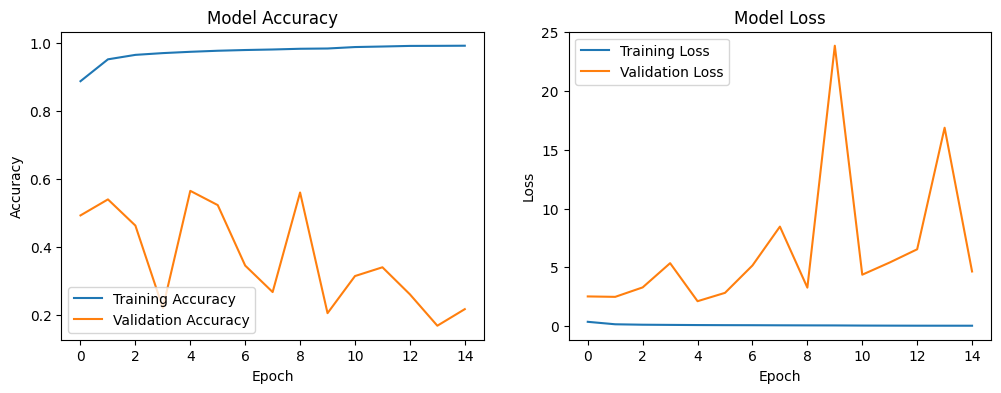

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


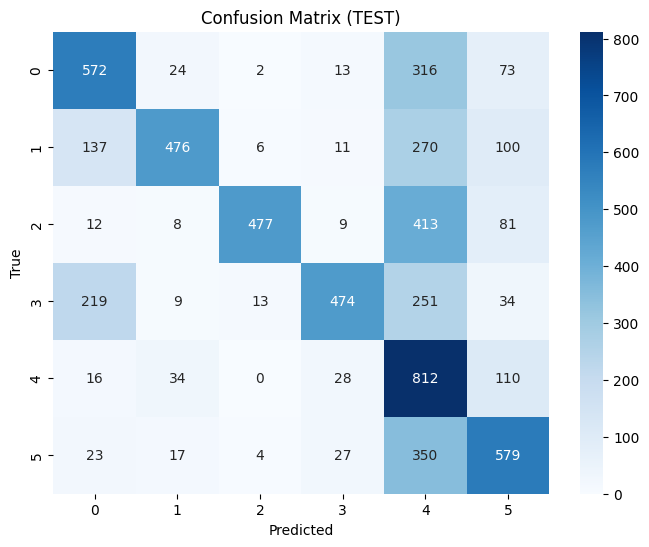

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1427 - loss: 4.1897

TEST2 accuracy: 17.35%


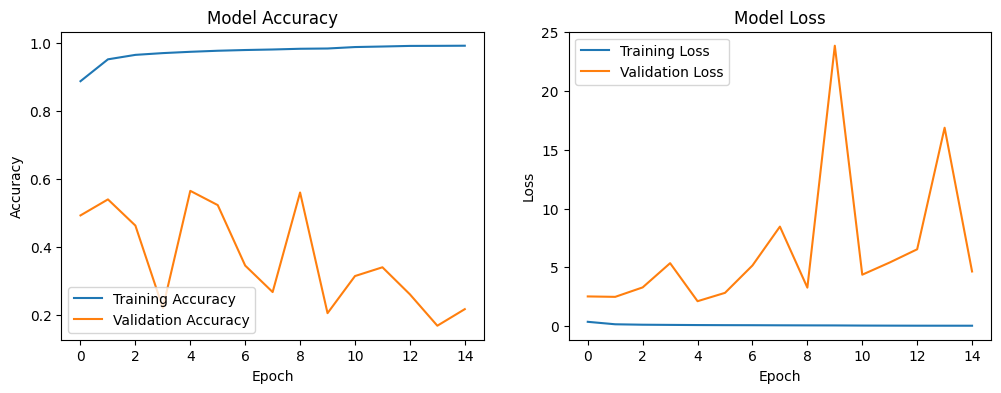

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step


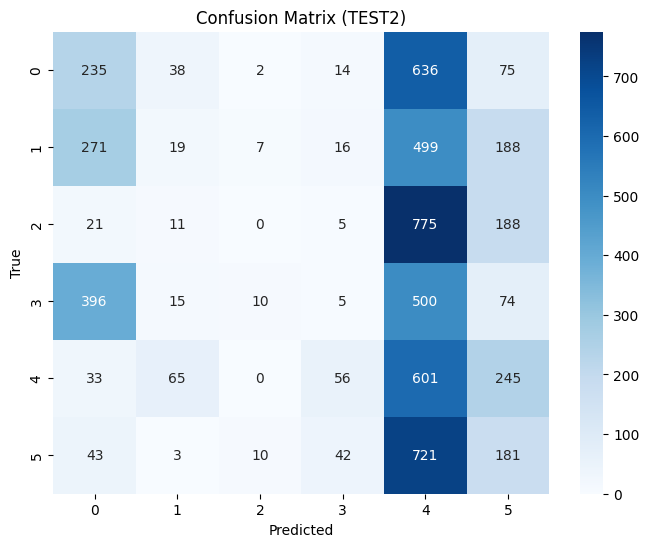


Task 2: Fine-tuning with TEST data...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.5553 - loss: 2.2742 - val_accuracy: 0.4093 - val_loss: 1.5698 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6384 - loss: 1.2969 - val_accuracy: 0.6252 - val_loss: 0.9882 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.7237 - loss: 0.8637 - val_accuracy: 0.7352 - val_loss: 0.7335 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.7594 - loss: 0.7306 - val_accuracy: 0.8000 - val_loss: 0.5839 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.7914 - loss: 0.6150 - val_accuracy: 0.8415 - val_loss: 0.4912 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.8069 - loss: 0.5415 - val_accuracy: 0.8660 - val_loss: 0.4306 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accurac

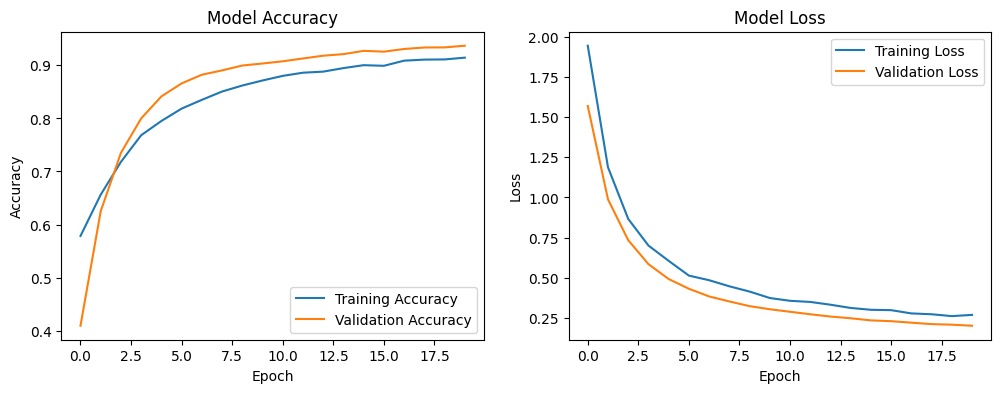

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


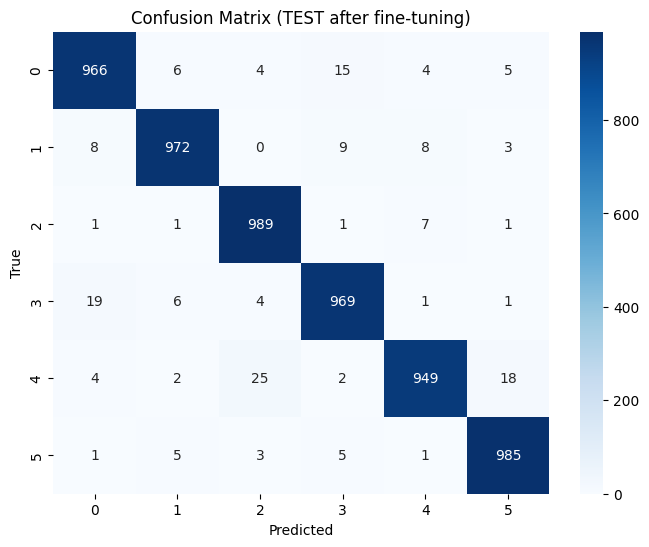

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9314 - loss: 0.2176

TEST2 accuracy after fine-tuning: 93.70%


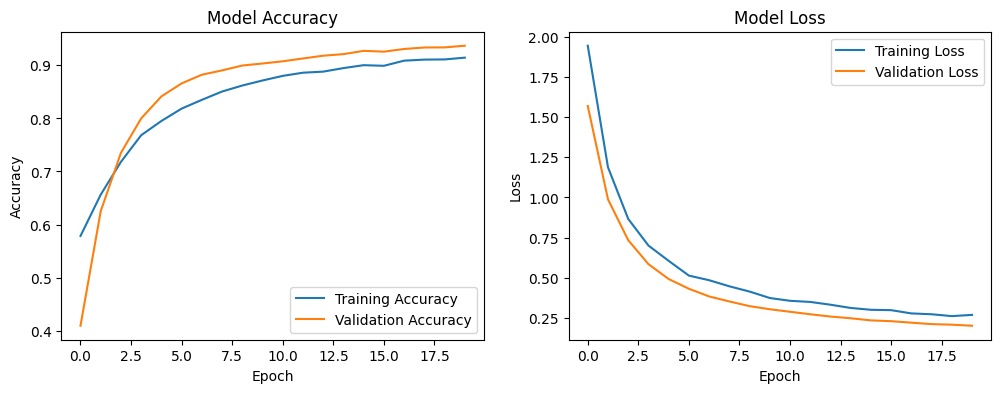

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


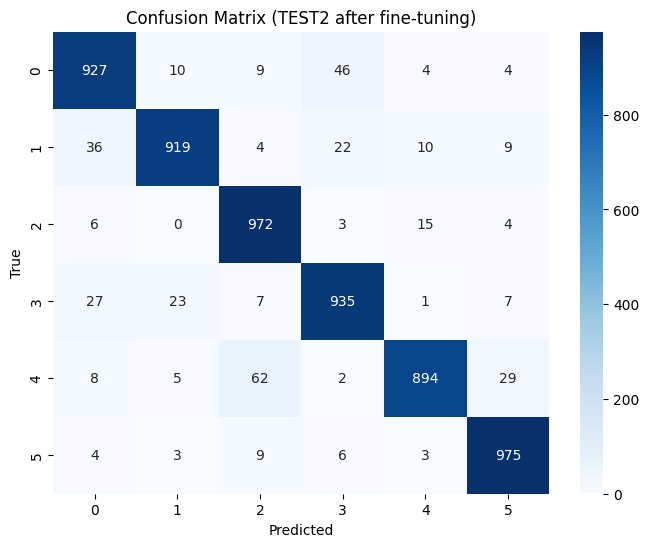

In [21]:
def plot_results(history, model, X_test, y_test, dataset_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion matrix
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({dataset_name})')
    plt.show()

if __name__ == "__main__":
    train_and_evaluate()